In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import os
path_to_dataset = "../input/homework1/training_data_final/"
tfk = tf.keras
tfkl = tfk.layers

In [2]:
import PIL
import random

# load images
species = list()
labels = list()
for dirname, folders, _ in os.walk(path_to_dataset):

    for folder in sorted(folders):
        print(dirname + folder)
        for _, _, filenames in os.walk(dirname + folder):
            for filename in filenames:
                a = np.array(PIL.Image.open(path_to_dataset + folder + "/" + filename).convert("RGB"))
                species.append(a)
                labels.append(int(folder[-1])-1)

../input/homework1/training_data_final/Species1
../input/homework1/training_data_final/Species2
../input/homework1/training_data_final/Species3
../input/homework1/training_data_final/Species4
../input/homework1/training_data_final/Species5
../input/homework1/training_data_final/Species6
../input/homework1/training_data_final/Species7
../input/homework1/training_data_final/Species8


In [3]:
from sklearn.model_selection import train_test_split
species = np.array(species)
labels = np.array(labels)
labels = tfk.utils.to_categorical(labels, num_classes = 8)
print(species.shape)
print(labels.shape)

(3542, 96, 96, 3)
(3542, 8)


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(species, labels, test_size = 0.2, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1/0.8, stratify=y_train_val)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale = 1/255.)
valid_data_gen = ImageDataGenerator(rescale = 1/255.)
test_data_gen = ImageDataGenerator(rescale = 1/255.)

train_gen = train_data_gen.flow(x=X_train, y=y_train, batch_size=8)
valid_gen = valid_data_gen.flow(x=X_val,y=y_val,batch_size=8)
test_gen = test_data_gen.flow(x=X_test,y=y_test,batch_size=8)

In [6]:
# model
input_shape = (96, 96, 3)
epochs = 200
def build_model(input_shape):

    model = tfk.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='input_layer'))
    model.add(tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    ))
    model.add(tfkl.MaxPooling2D())
    model.add(tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    ))
    model.add(tfkl.MaxPooling2D())
    model.add(tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    ))
    model.add(tfkl.MaxPooling2D())
    model.add(tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    ))
    model.add(tfkl.MaxPooling2D())
    model.add(tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform()
    ))
    model.add(tfkl.MaxPooling2D())
    model.add(tfkl.Flatten(name="Flatten"))
    model.add(tfkl.Dropout(0.3))
    # classification layer
    model.add(tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(), activation='relu'))
    model.add(tfkl.Dropout(0.3))
    # output layer
    model.add(tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(), name='output_layer'))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [7]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

In [8]:
# create model & callbacks
model = build_model(input_shape)
model.summary()

# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

2022-11-12 11:10:13.706533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:10:13.827669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:10:13.828557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 11:10:13.829805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [9]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200


2022-11-12 11:10:16.527122: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-12 11:10:17.994869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


310/310 [==============================] - 10s 8ms/step - loss: 1.9018 - accuracy: 0.2607 - val_loss: 1.6172 - val_accuracy: 0.2873
Epoch 2/200
310/310 [==============================] - 2s 7ms/step - loss: 1.6725 - accuracy: 0.3261 - val_loss: 1.5226 - val_accuracy: 0.4169
Epoch 3/200
310/310 [==============================] - 2s 7ms/step - loss: 1.5854 - accuracy: 0.3467 - val_loss: 1.5452 - val_accuracy: 0.3465
Epoch 4/200
310/310 [==============================] - 2s 8ms/step - loss: 1.4710 - accuracy: 0.4036 - val_loss: 1.4393 - val_accuracy: 0.4986
Epoch 5/200
310/310 [==============================] - 2s 7ms/step - loss: 1.3829 - accuracy: 0.4520 - val_loss: 1.3042 - val_accuracy: 0.4901
Epoch 6/200
310/310 [==============================] - 2s 7ms/step - loss: 1.2429 - accuracy: 0.5359 - val_loss: 1.2220 - val_accuracy: 0.5606
Epoch 7/200
310/310 [==============================] - 2s 7ms/step - loss: 1.1749 - accuracy: 0.5492 - val_loss: 1.1849 - val_accuracy: 0.5803
Epoch 8/20

89/89 [==============================] - 0s 4ms/step - loss: 1.4515 - accuracy: 0.5755
{'loss': 1.4514800310134888, 'accuracy': 0.5754584074020386}


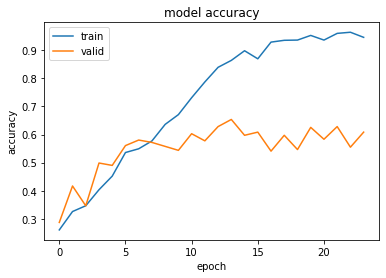

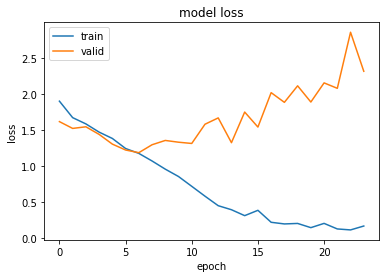

In [10]:
model_noaug_test_metrics = model.evaluate(test_gen, return_dict=True)
print(model_noaug_test_metrics)

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [11]:
model.save("data_augmentation_experiments/CNN_Aug_Best")
!zip -r modello.zip ./data_augmentation_experiments/CNN_Aug_Best


  adding: data_augmentation_experiments/CNN_Aug_Best/ (stored 0%)
  adding: data_augmentation_experiments/CNN_Aug_Best/assets/ (stored 0%)
  adding: data_augmentation_experiments/CNN_Aug_Best/keras_metadata.pb (deflated 93%)
  adding: data_augmentation_experiments/CNN_Aug_Best/variables/ (stored 0%)
  adding: data_augmentation_experiments/CNN_Aug_Best/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: data_augmentation_experiments/CNN_Aug_Best/variables/variables.index (deflated 68%)
  adding: data_augmentation_experiments/CNN_Aug_Best/saved_model.pb (deflated 89%)
